In [2]:
import pandas as pd
import numpy as np
from collections import Counter
import math
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler
from utils.utils import eval_run, plot_conf_matrix

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.linear_model import Lasso

from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


In [3]:
table_1 = pd.read_csv(r"data/table_1.csv", sep=';')
table_2 = pd.read_csv(r"data/table_2.csv", sep=';')

In [4]:
table_2.sample(10)

,POUG,TRE,ID,ZUB,VOL,UIO,VBNM,Type,OIN
86,0,0.000,86,t,f,NaN,f,n,42.25
2092,0,5.125,2092,f,t,wwww,f,y,42.00
2868,0,7.415,2868,t,t,wwww,f,y,34.25
3689,3,5.000,3689,t,t,wwww,t,y,NaN
3443,0,0.000,3443,f,f,uuuu,f,y,71.58
1468,0,0.375,1468,t,t,wwww,f,y,27.00
2457,11,5.335,2457,f,t,wwww,t,y,28.92
2797,1,0.460,2797,f,t,wwww,t,y,23.17
976,0,2.460,976,f,f,uuuu,f,y,22.50
3019,5,5.000,3019,f,t,wwww,t,y,55.92


### First, we will try to merge the two tables by the unique ID of the samples.

In [5]:
id_order = list(table_2['ID'])
print(len(id_order))
print(len(set(id_order)))

4070
3700


There are duplicates in the data; remove them (first making sure that they are complete duplicates):

In [6]:
table_2[table_2['ID']==305]

,POUG,TRE,ID,ZUB,VOL,UIO,VBNM,Type,OIN
305,0,3.25,305,f,f,uuuu,f,n,22.25
3784,0,3.25,305,f,f,uuuu,f,n,22.25
3827,0,3.25,305,f,f,uuuu,f,n,22.25
4044,0,3.25,305,f,f,uuuu,f,n,22.25


Remove duplicates

In [7]:
table_2 = table_2.drop_duplicates(subset=['ID'])
table_1 = table_1.drop_duplicates(subset=['ID'])

Order the IDs in table one in the same way as in table 2 to further merge them.

In [8]:
id_order = list(table_2['ID'])
table_1['ID'] = pd.Categorical(table_1['ID'], categories=id_order, ordered=False)
data = pd.merge(table_1, table_2, on='ID', how='inner') 

In [10]:
data

,ID,UKL,GJAH,ZIK,HUI,ERZ,CDx,BJZHD,NKJUD,LPI,BJKG,POUG,TRE,ZUB,VOL,UIO,VBNM,Type,OIN
0,0,160,oooo,x,oooo,www,5.0,vvvv,80.0,800000.0,qqqq,1,1.750,t,f,uuuu,t,n,17.92
1,1,153,rrr,NaN,uuu,pppp,0.0,mmm,200.0,2000000.0,qqqq,0,0.290,f,f,wwww,f,n,16.92
2,2,5,oooo,x,oooo,www,19.0,hh,96.0,960000.0,hh,1,0.000,f,f,wwww,t,n,31.25
3,3,9,oooo,NaN,oooo,www,120.0,kkk,0.0,0.0,qqq,0,0.335,f,f,uuuu,f,n,48.17
4,4,40,oooo,y,oooo,www,0.0,mmm,232.0,2320000.0,qqqq,0,0.500,t,f,wwww,f,n,32.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3695,3695,74,oooo,x,oooo,www,26726.0,sss,NaN,NaN,qqqq,5,2.710,f,t,uuuu,t,y,18.75
3696,3696,179,oooo,x,oooo,www,0.0,sss,120.0,1200000.0,qqqq,5,8.500,t,t,uuuu,t,y,23.50
3697,3697,82,oooo,NaN,oooo,www,221.0,vvvv,0.0,0.0,qqqq,12,4.500,t,t,wwww,t,y,34.17
3698,3698,13,oooo,NaN,oooo,www,3.0,yyy,100.0,1000000.0,qqqq,5,3.750,t,t,wwww,t,y,27.83


### Let's examine each feature type

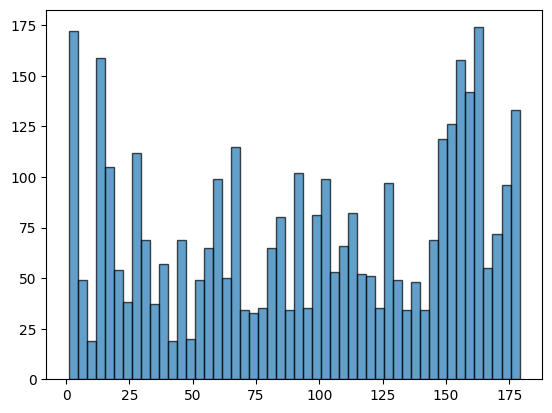

1
179
95.68837837837837
99.0
0    1
Name: UKL, dtype: int64


In [10]:
plt.hist(list(data['UKL']), bins=50, edgecolor='black', alpha=0.7)
plt.show()
print(min(list(data['UKL'])))
print(max(list(data['UKL'])))
print(np.mean(list(data['UKL'])))
print(data['UKL'].median())
print(data['UKL'].mode())

In [11]:
Counter(data["GJAH"])

Counter({'oooo': 3055, 'rrr': 549, nan: 64, 'ii': 32})

In [12]:
Counter(data["ZIK"])

Counter({'x': 1023, nan: 2145, 'y': 532})

ZIK feature seems not so useful, as the majority samples don't have any value for it (more than half).

We can turn it into another feature where having a value or not is a feature itself.

In [11]:
data['ZIK_is_missing'] = data['ZIK'].isna()
data = data.drop(columns=['ZIK'])

I checked how different options reflect on accuracy/f-score:

- Removing ZIK variable: 
    - Logistic regression: Accuracy: 0.9473, F1_score: 0.9400

- Transforming ZIK into a new feature:
    - Logistic regression: Accuracy: 0.9541, F1_score: 0.9498

Based on that, I proceed with creating a new variable "ZIK_is_missing".

In [13]:
Counter(data["HUI"])

Counter({'oooo': 3430, 'uuu': 189, 'rrr': 81})

In [14]:
Counter(data["ERZ"])

Counter({'www': 3055, 'pppp': 549, nan: 64, 'nnn': 32})

0.0
100000.0
2246.705945945946
113.0
0    0.0
Name: CDx, dtype: float64


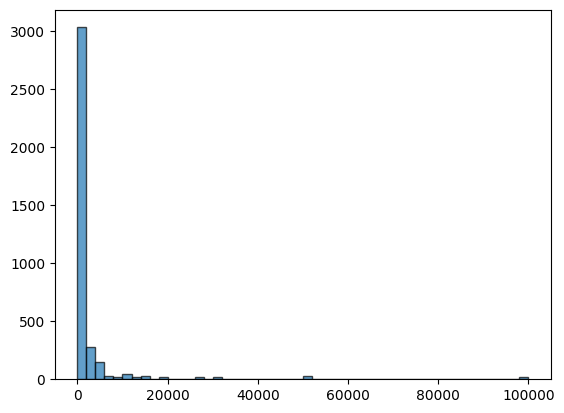

In [14]:
print(min(list(data['CDx'])))
print(max(list(data['CDx'])))
print(np.mean(list(data['CDx'])))
print(data['CDx'].median())
print(data['CDx'].mode())


plt.hist(list(data['CDx']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

In [15]:
Counter(data["BJZHD"])

Counter({'vvvv': 787,
         'mmm': 170,
         'hh': 136,
         'kkk': 191,
         'lll': 39,
         'sss': 612,
         'yyy': 457,
         'ooo': 179,
         'ee': 553,
         'xxx': 33,
         'zzz': 340,
         'ggg': 137,
         nan: 66})

0.0
1160.0
nan
120.0
0    0.0
Name: NKJUD, dtype: float64


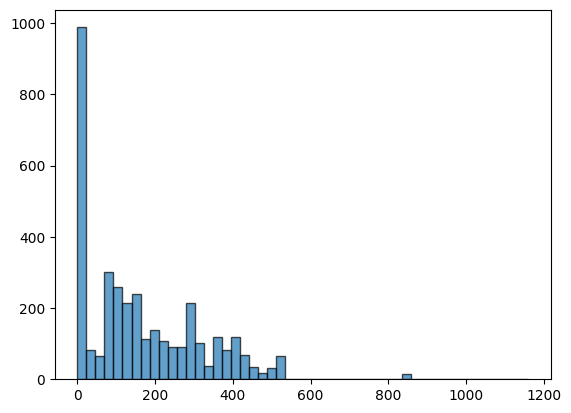

In [17]:
print(min(list(data['NKJUD'])))
print(max(list(data['NKJUD'])))
print(np.mean(list(data['NKJUD'])))
print(data['NKJUD'].median())
print(data['NKJUD'].mode())

plt.hist(list(data['NKJUD']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

0.0
11600000.0
nan
1200000.0
0    0.0
Name: LPI, dtype: float64


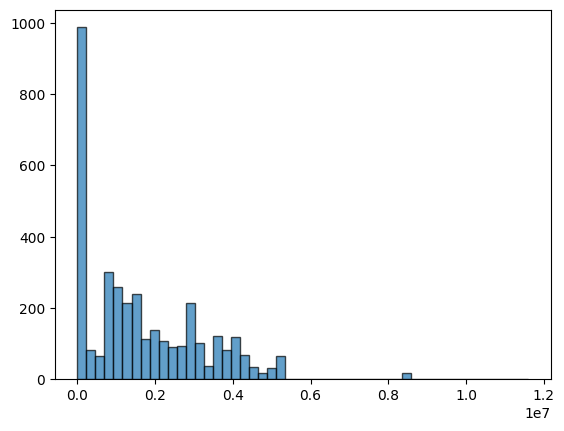

In [28]:
print(min(list(data['LPI'])))
print(max(list(data['LPI'])))
print(np.mean(list(data['LPI'])))
print(data['LPI'].median())
print(data['LPI'].mode())

plt.hist(list(data['LPI']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

In [29]:
Counter(data["BJKG"])

Counter({'qqqq': 2015,
         'hh': 154,
         'qqq': 17,
         'hhhh': 970,
         'lll': 37,
         'yy': 359,
         'ppp': 33,
         'bbb': 49,
         nan: 66})

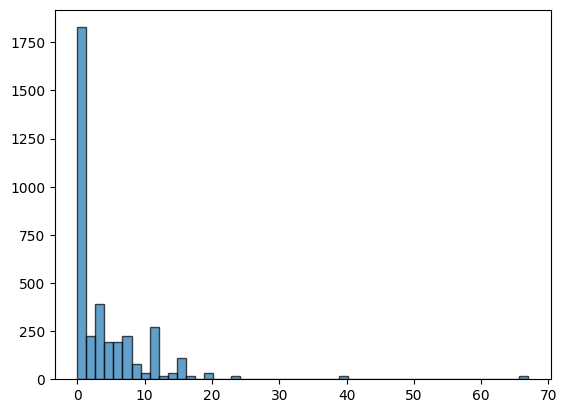

In [30]:
Counter(data["POUG"])

plt.hist(list(data['POUG']), bins=50, edgecolor='black', alpha=0.7)
plt.show()

0.0
28.5
3.4394959459459455
1.75
0.0


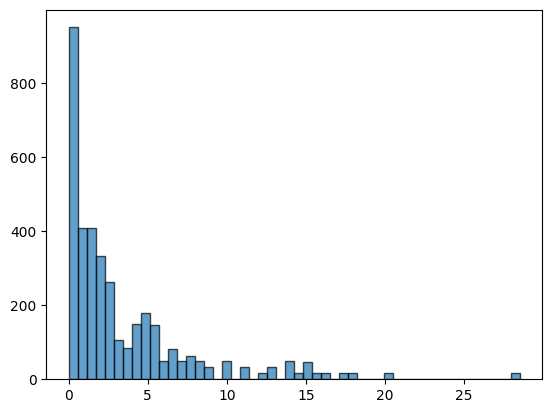

In [21]:
print(min(list(data['TRE'])))
print(max(list(data['TRE'])))
print(np.mean(list(data['TRE'])))
print(data['TRE'].median())
print(data['TRE'].mode().iloc[0])

plt.hist(list(data['TRE']), bins=50, edgecolor='black', alpha=0.7)
plt.show()


In [22]:
Counter(data["ZUB"])

Counter({'t': 1776, 'f': 1924})

In [23]:
Counter(data["VOL"])

Counter({'f': 529, 't': 3171})

In [24]:
Counter(data["UIO"])

Counter({'uuuu': 1279, 'wwww': 2382, nan: 39})

In [25]:
Counter(data["VBNM"])

Counter({'t': 2239, 'f': 1461})

In [26]:
print(min(list(data['OIN'])))
print(max(list(data['OIN'])))
print(np.mean(list(data['OIN'])))
print(data['OIN'].median())
print(data['OIN'].mode())

13.75
80.25
nan
28.67
0    23.25
Name: OIN, dtype: float64


In [27]:
Counter(data["Type"])

Counter({'n': 276, 'y': 3424})

##### Looking at our labels, we see that there is a major class imbalance. Even if we build a model that only predicts yes", we will be right in almost 92% percent of cases.

We will deal with this later by trying different strategis:

- assigning higher penalty for mistakes on a smaller class
- resampling

In [12]:
100 - 276/3424*100

91.9392523364486

Now we impute missing values of the features, in this case by replacing them with the mode (most commonly met value).

In [14]:
for index, row in data.iterrows():
    for column_name, value in row.items():
        if isinstance(value, (int, float)) and math.isnan(value):
            try:
                mode_value = data[column_name].mode().iloc[0]
                data.at[index, column_name] = mode_value
            except TypeError:
                continue

Check if numerical variables are correlated. Our predictors should be independent from each other as much as possible.

In [15]:
feature_floats = data.select_dtypes(include=['float64'])
feature_names = list(feature_floats.columns)
correlations = data[feature_names].corr()

In [16]:
correlations

,CDx,NKJUD,LPI,TRE,OIN
CDx,1.000000,0.145232,0.145232,-0.004123,-0.007921
NKJUD,0.145232,1.000000,1.000000,-0.195718,-0.149966
LPI,0.145232,1.000000,1.000000,-0.195718,-0.149966
TRE,-0.004123,-0.195718,-0.195718,1.000000,0.511143
OIN,-0.007921,-0.149966,-0.149966,0.511143,1.000000


There doesn't seem to be a large correlation between numerical variables; only OIN and TRE have a correlation of around 0.5, which is not extremely high.

### Create dummy variables for categorical variables

In [17]:
print(data.dtypes)

ID                  int64
UKL                 int64
GJAH               object
HUI                object
ERZ                object
CDx               float64
BJZHD              object
NKJUD             float64
LPI               float64
BJKG               object
POUG                int64
TRE               float64
ZUB                object
VOL                object
UIO                object
VBNM               object
Type               object
OIN               float64
ZIK_is_missing       bool
dtype: object


In [18]:
features_object = data.select_dtypes(include=['object', "bool"])
features_object_names = list(features_object.columns)

In [19]:
data_with_dummies = pd.get_dummies(data, columns=features_object_names, drop_first=True) # drop_first=True to avoid multicollinearity

Now we deal with outliers: if they are more than 2 standart deviations away from the mean, we cap them to the +-2SD range

In [20]:
features_numerical = data.select_dtypes(include=['int64', 'float64'])
features_numerical_names = list(features_numerical.columns)
#drop the ID column
features_numerical_names = features_numerical_names[1:]

In [21]:
features_numerical_names

['UKL', 'CDx', 'NKJUD', 'LPI', 'POUG', 'TRE', 'OIN']

In [22]:
# now we apply Winsorization to each numerical feature
for feature in features_numerical_names:
    data_with_dummies[feature] = winsorize(data_with_dummies[feature], limits=[0.05, 0.05])

Now we do data normalization. 

We use StandardScaler (Standardization) instead of MinMaxScaler (from 0 to 1) because if there are outliers, the majority of the values will be squeezed in a small range. Also we don't know from the data what are "natural bounds" of variables (like range of the pixel values, temperature, etc.)

In [24]:
scaler = StandardScaler()
data_with_dummies[features_numerical_names] = scaler.fit_transform(data_with_dummies[features_numerical_names])

# to convert True/False into 0/1
boolean_columns = data_with_dummies.select_dtypes(include='bool').columns
data_with_dummies[boolean_columns] = data_with_dummies[boolean_columns].astype(int)

### We run correlation analysis again

In [25]:
correlation_matrix = data_with_dummies.corr()

In [26]:
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))
high_corr = upper_triangle[upper_triangle > 0.7]

print("Correlations greater than 0.7:")
print(high_corr.dropna(how='all').dropna(axis=1, how='all'))

Correlations greater than 0.7:
           LPI  ERZ_pppp  ERZ_www   BJKG_hh
NKJUD      1.0       NaN      NaN       NaN
GJAH_oooo  NaN       NaN      1.0       NaN
GJAH_rrr   NaN       1.0      NaN       NaN
BJZHD_hh   NaN       NaN      NaN  0.822299


##### We see perfect correlation between NKJUD & LPI, GJAH_rrr and ERZ_pppp, and GJAH_oooo and ERZ_www.

We will remove one variable in each pair and see how it affects the model performance. 

We will use a function that will evaluate both set of predictors - with and without collinearity: **eval_run**

In [27]:
data_dummies_dropped_collinear = data_with_dummies.drop(columns=['NKJUD', "ERZ_pppp", "ERZ_www"])

Results of the analysis:

- **Logistic Regression**: 

    - Preserve collinear vars: 
        - Accuracy: 0.9541, F1_score: 0.9498
    - Remove collinear vars: 
        - Accuracy: 0.9527, F1_score: 0.9481

- **Ridge Classification**
    - Preserve collinear vars: 
        - Accuracy: 0.9432, F1_score: 0.9385
    - Remove collinear vars: 
        - Accuracy: 0.9446, F1_score: 0.9397

- **Random forest**
    - Preserve collinear vars: 
        - Accuracy: **0.9757**, F1_score: **0.9741**
    - Remove collinear vars: 
        - Accuracy: **0.9757**, F1_score: **0.9741**


##### For some reason, a model with collinear variables performs better on a test set on logistic regression and Ridge classification. 

However, the less complex our model is, the more interpretable it is, and the performance loss isn't drastic.

Based on the high performance of **Random forests**, I decided to proceed with them. Not only did they have a high accuracy, but also highest F1-score, and were able to detect the most instances of a minority class.

They might also be good since they don't assume a linear relationship in our data.

Accuracy: 0.9757
F1_score: 0.9741


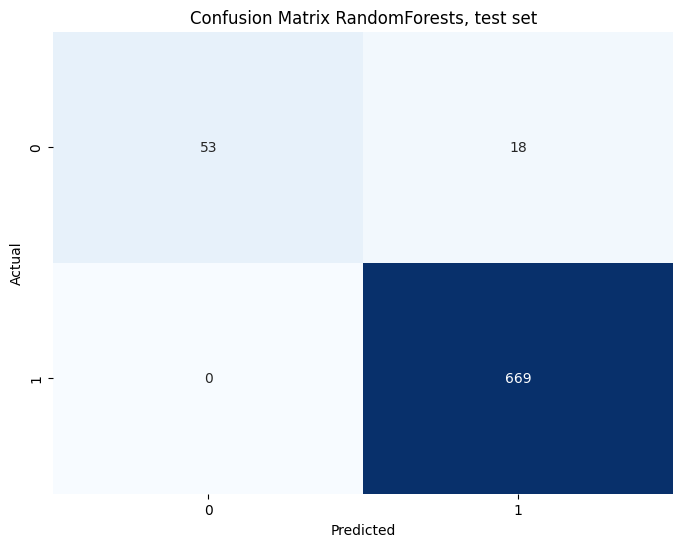

In [28]:
eval_run(data_with_dummies, model='random_forest')

Accuracy: 0.9757
F1_score: 0.9741


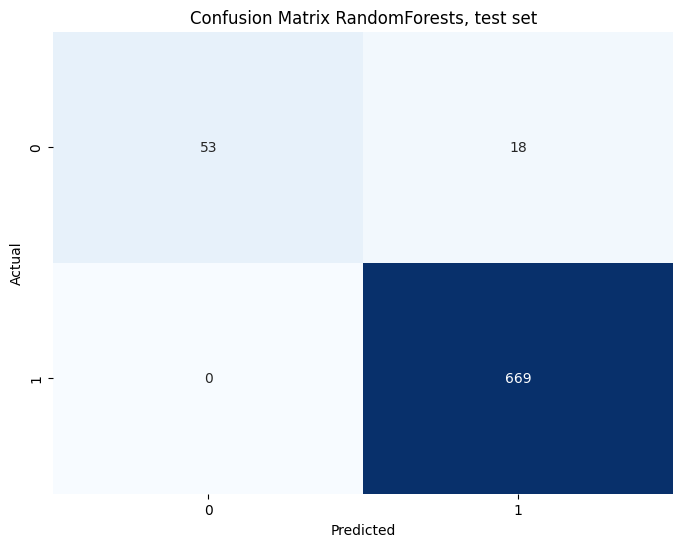

In [29]:
eval_run(data_dummies_dropped_collinear, model='random_forest')

### Now we will try to enhance the Random Forests performance

#### 1. Handling class imbalance

We will add a class_weight = 'balanced' parameter to increase punishment for less represented labels.

In [28]:
# These are the weights class_weight = 'balanced' will provide.
print("Error weight to class 'no':", 3700/(2*276))
print("Error weight to class 'yes':", 3700/(2*3424))

Error weight to class 'no': 6.702898550724638
Error weight to class 'yes': 0.540303738317757


In [29]:
predictors = list(data_dummies_dropped_collinear.columns)
predictors.remove("ID")
predictors.remove("Type_y")

X = data_dummies_dropped_collinear[predictors]
y = data_dummies_dropped_collinear['Type_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### 2. Find optimal hyperparameters using GridSearch

- number of trees - optimal number of trees
- depth - optimal depth to prevent overfitting
- maximum number of features - maximum number of features to consider at each split

### First let's optimize for accuracy

In [81]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': list(range(1, len(predictors), 5))
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters: {best_params}")
print(f"Best cross-validated score: {best_score}")

Best parameters: {'max_depth': 20, 'max_features': 6, 'n_estimators': 50}
Best cross-validated score: 0.9881756756756757


### Now let's optimize for F1-score

In [83]:
param_grid = {
    'max_depth': [3, 5, 7, 10, 15, 20, 25],
    'n_estimators': [10, 50, 100, 200, 300, 400, 500],
    'max_features': list(range(1, len(predictors), 5))
}

rf = RandomForestClassifier(class_weight='balanced', random_state=42)

f1_scorer = make_scorer(f1_score)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring=f1_scorer, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print(f"Best parameters f1: {best_params}")
print(f"Best cross-validated score f1: {best_score}")

Best parameters f1: {'max_depth': 20, 'max_features': 6, 'n_estimators': 50}
Best cross-validated score f1: 0.9936896231273664


Best hyperparameters coincide for F1-score and accuracy: 'max_depth': 20, 'max_features': 6, 'n_estimators': 50.

Let's build the model with these parameters and inspect the confusion matrix.

Accuracy: 0.9770
F1_score: 0.9756


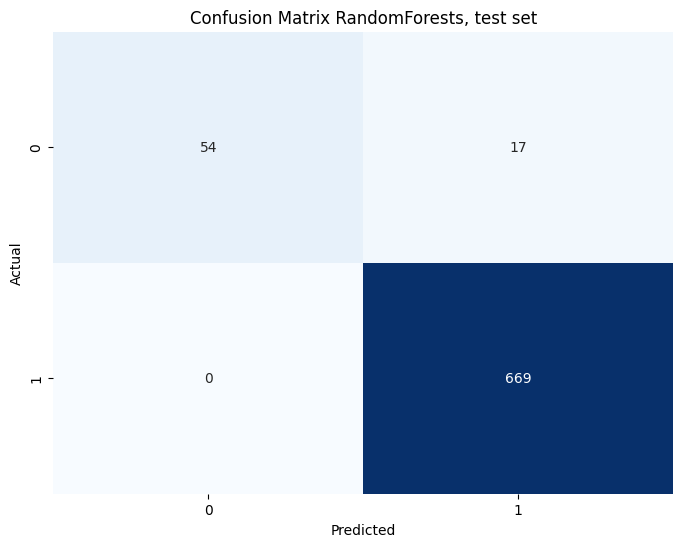

In [31]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, max_depth=20, max_features=6, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plot_conf_matrix(conf_matrix, y_test, "RandomForests")

### We were able to increase accuracy from 0.9757 to 0.9770, and f1-score from 0.9756 to 0.9741.

In [32]:
importances = rf.feature_importances_

feature_names = X.columns  

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df[:10])

    Feature  Importance
29    VOL_t    0.348241
4       TRE    0.097208
0       UKL    0.069255
3      POUG    0.068008
1       CDx    0.067759
2       LPI    0.056992
5       OIN    0.053474
31   VBNM_t    0.041375
28    ZUB_t    0.013779
8   HUI_rrr    0.013165


The most influential feature seems to be  **VOL_t***. 

Let's try to build a model on top-10 features only, iteratively adding one by one.

Vol_t.
Accuracy: **0.9027**
F1_score: **0.9112**

Vol_t, TRE.
Accuracy: **0.9041**
F1_score: **0.9107**

Vol_t, TRE, UKL. 
Accuracy: **0.9730**
F1_score: **0.9710**

Vol_t, TRE, UKL, POUG.
Accuracy: **0.9730**
F1_score: **0.9710**

Vol_t, TRE, UKL, POUG, CDx.
Accuracy: **0.9689**
F1_score: **0.9662**

Vol_t, TRE, UKL, POUG, CDx, LPI.
Accuracy: **0.9730**
F1_score: **0.9710**

Vol_t, TRE, UKL, POUG, CDx, LPI, OIN.
Accuracy: **0.9743**
F1_score: **0.9725**

Vol_t, TRE, UKL, POUG, CDx, LPI, OIN, VBNM_t.
Accuracy: **0.9730**
F1_score: **0.9710**

Vol_t, TRE, UKL, POUG, CDx, LPI, OIN, VBNM_t, ZUB_t.
Accuracy: **0.9716**
F1_score: **0.9694**

Vol_t, TRE, UKL, POUG, CDx, LPI, OIN, VBNM_t, ZUB_t, HUI_rrr.
Accuracy: **0.9757**
F1_score: **0.9741**

In [33]:
predictors = ['VOL_t', "TRE", "UKL", "POUG", "CDx", "LPI", "OIN", "VBNM_t", "ZUB_t", "HUI_rrr"]

X = data_dummies_dropped_collinear[predictors]
y = data_dummies_dropped_collinear['Type_y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
rf = RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.4f}")
conf_matrix = confusion_matrix(y_test, y_pred)

Accuracy: 0.9757
F1_score: 0.9741


#### Let's go even further and try resampling techniques to tackle the class imbalance with a new approach.

In [60]:
predictors = list(data_dummies_dropped_collinear.columns)
predictors.remove("ID")
predictors.remove("Type_y")
X = data_dummies_dropped_collinear[predictors]
y = data_dummies_dropped_collinear['Type_y']

1. **SMOTE (Synthetic Minority Over-sampling Technique)** - here we create synthetic samples by interpolating between samples from the minority class.

Accuracy: 0.9819819820
F1_score: 0.9810224014


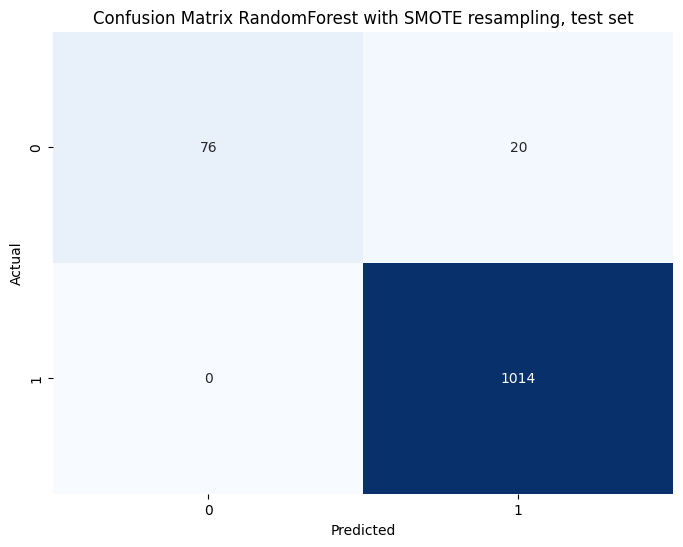

In [79]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

model_smote = RandomForestClassifier(random_state=42)
model_smote.fit(X_resampled, y_resampled)

y_pred = model_smote.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.10f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.10f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plot_conf_matrix(conf_matrix, y_test, "RandomForest with SMOTE resampling")

2. **Random oversampling** - we oversample the minority class datapoints, duplicating some samples.

Accuracy: 0.9801801802
F1_score: 0.9790040715


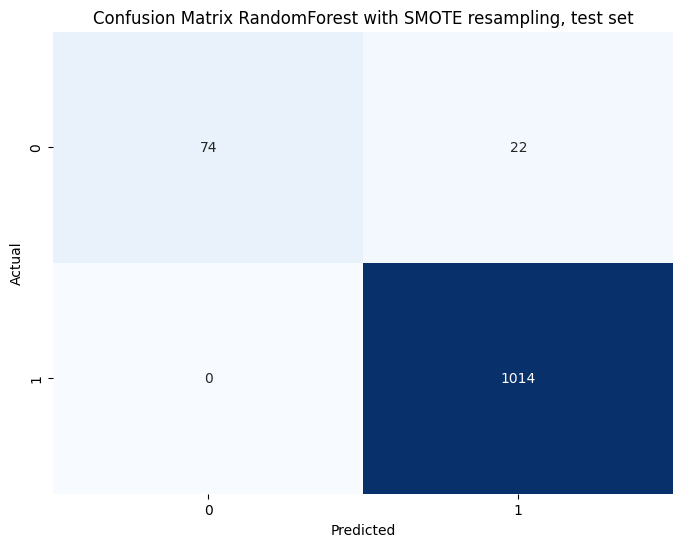

In [66]:
ros = RandomOverSampler()
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.10f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.10f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plot_conf_matrix(conf_matrix, y_test, "RandomForest with SMOTE resampling")

3. **Random undersampling** - here we undersample the majority class, taking less samples from it.

Accuracy: 0.9261261261
F1_score: 0.9321935078


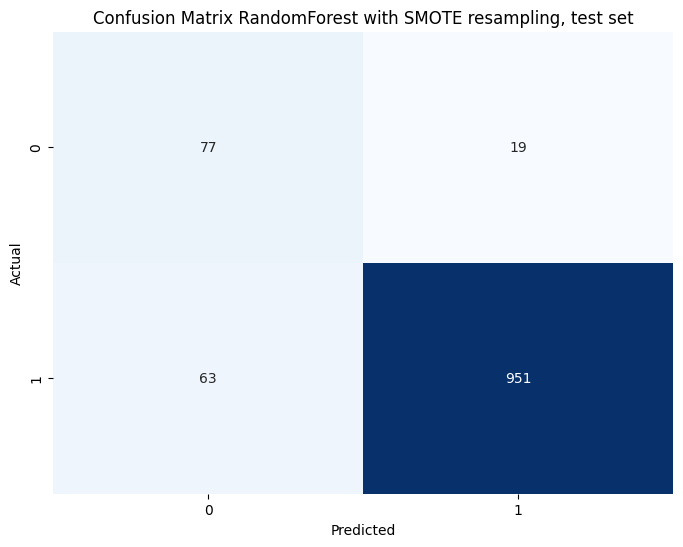

In [68]:
rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)
model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)

y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.10f}")

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1_score: {f1:.10f}")

conf_matrix = confusion_matrix(y_test, y_pred)
plot_conf_matrix(conf_matrix, y_test, "RandomForest with SMOTE resampling")

## Summary

In this dataset, there were multiple challenges, among them:

- different types of variables (numerical, categorical)
- noisy data (many features, some values missing)
- notable class imbalance.


To sum up, the best results were achieved using **RandomForest classifier** with synthetically creatied new samples for the minority class.

We achieved an accuracy of **0.98198** and an F1_score of **0.98102**. This is an improved from the baseline RandomForest classifier that had an accuracy of **0.9757** and an F1_score of **0.9741**.

If we knew the physical meaning of the variables, we could think more in depth about the **precision VS recall trade-off**, but as of now we prioritize **F1 score** since it takes into account both classes' performance. This is important in the case of class imbalance. 


Let's have a look at the important features of the best-performing model. We can observe that top important feature is still VOL_t.

In [80]:
importances = model_smote.feature_importances_
feature_names = X.columns  # or list of feature names
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
})

importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(importance_df[:10])

      Feature  Importance
29      VOL_t    0.344908
3        POUG    0.095135
4         TRE    0.083369
31     VBNM_t    0.079689
1         CDx    0.070700
0         UKL    0.053137
2         LPI    0.051626
5         OIN    0.039770
28      ZUB_t    0.022161
22  BJKG_hhhh    0.018951
